In [1]:
import string
from os.path import join
import glob
import json

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter



from naturalcogsci.helpers import get_project_root

PROJECT_ROOT = get_project_root()

mpl.rcParams.update(mpl.rc_params_from_file(join(PROJECT_ROOT, ".matplotlibrc")))

FIGWIDTH = mpl.rcParams["figure.figsize"][0]
CMAP = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
CATEGORYTRIALS = 120
REWARDTRIALS = 60
SMALLER_SIZE = 6



with open(join(PROJECT_ROOT, "data", "model_plot_params.json")) as f:
    plot_params = json.load(f)
plot_params = {k.replace("/", "_"): v for k, v in plot_params.items()}
main_feature_names = list(plot_params.keys())

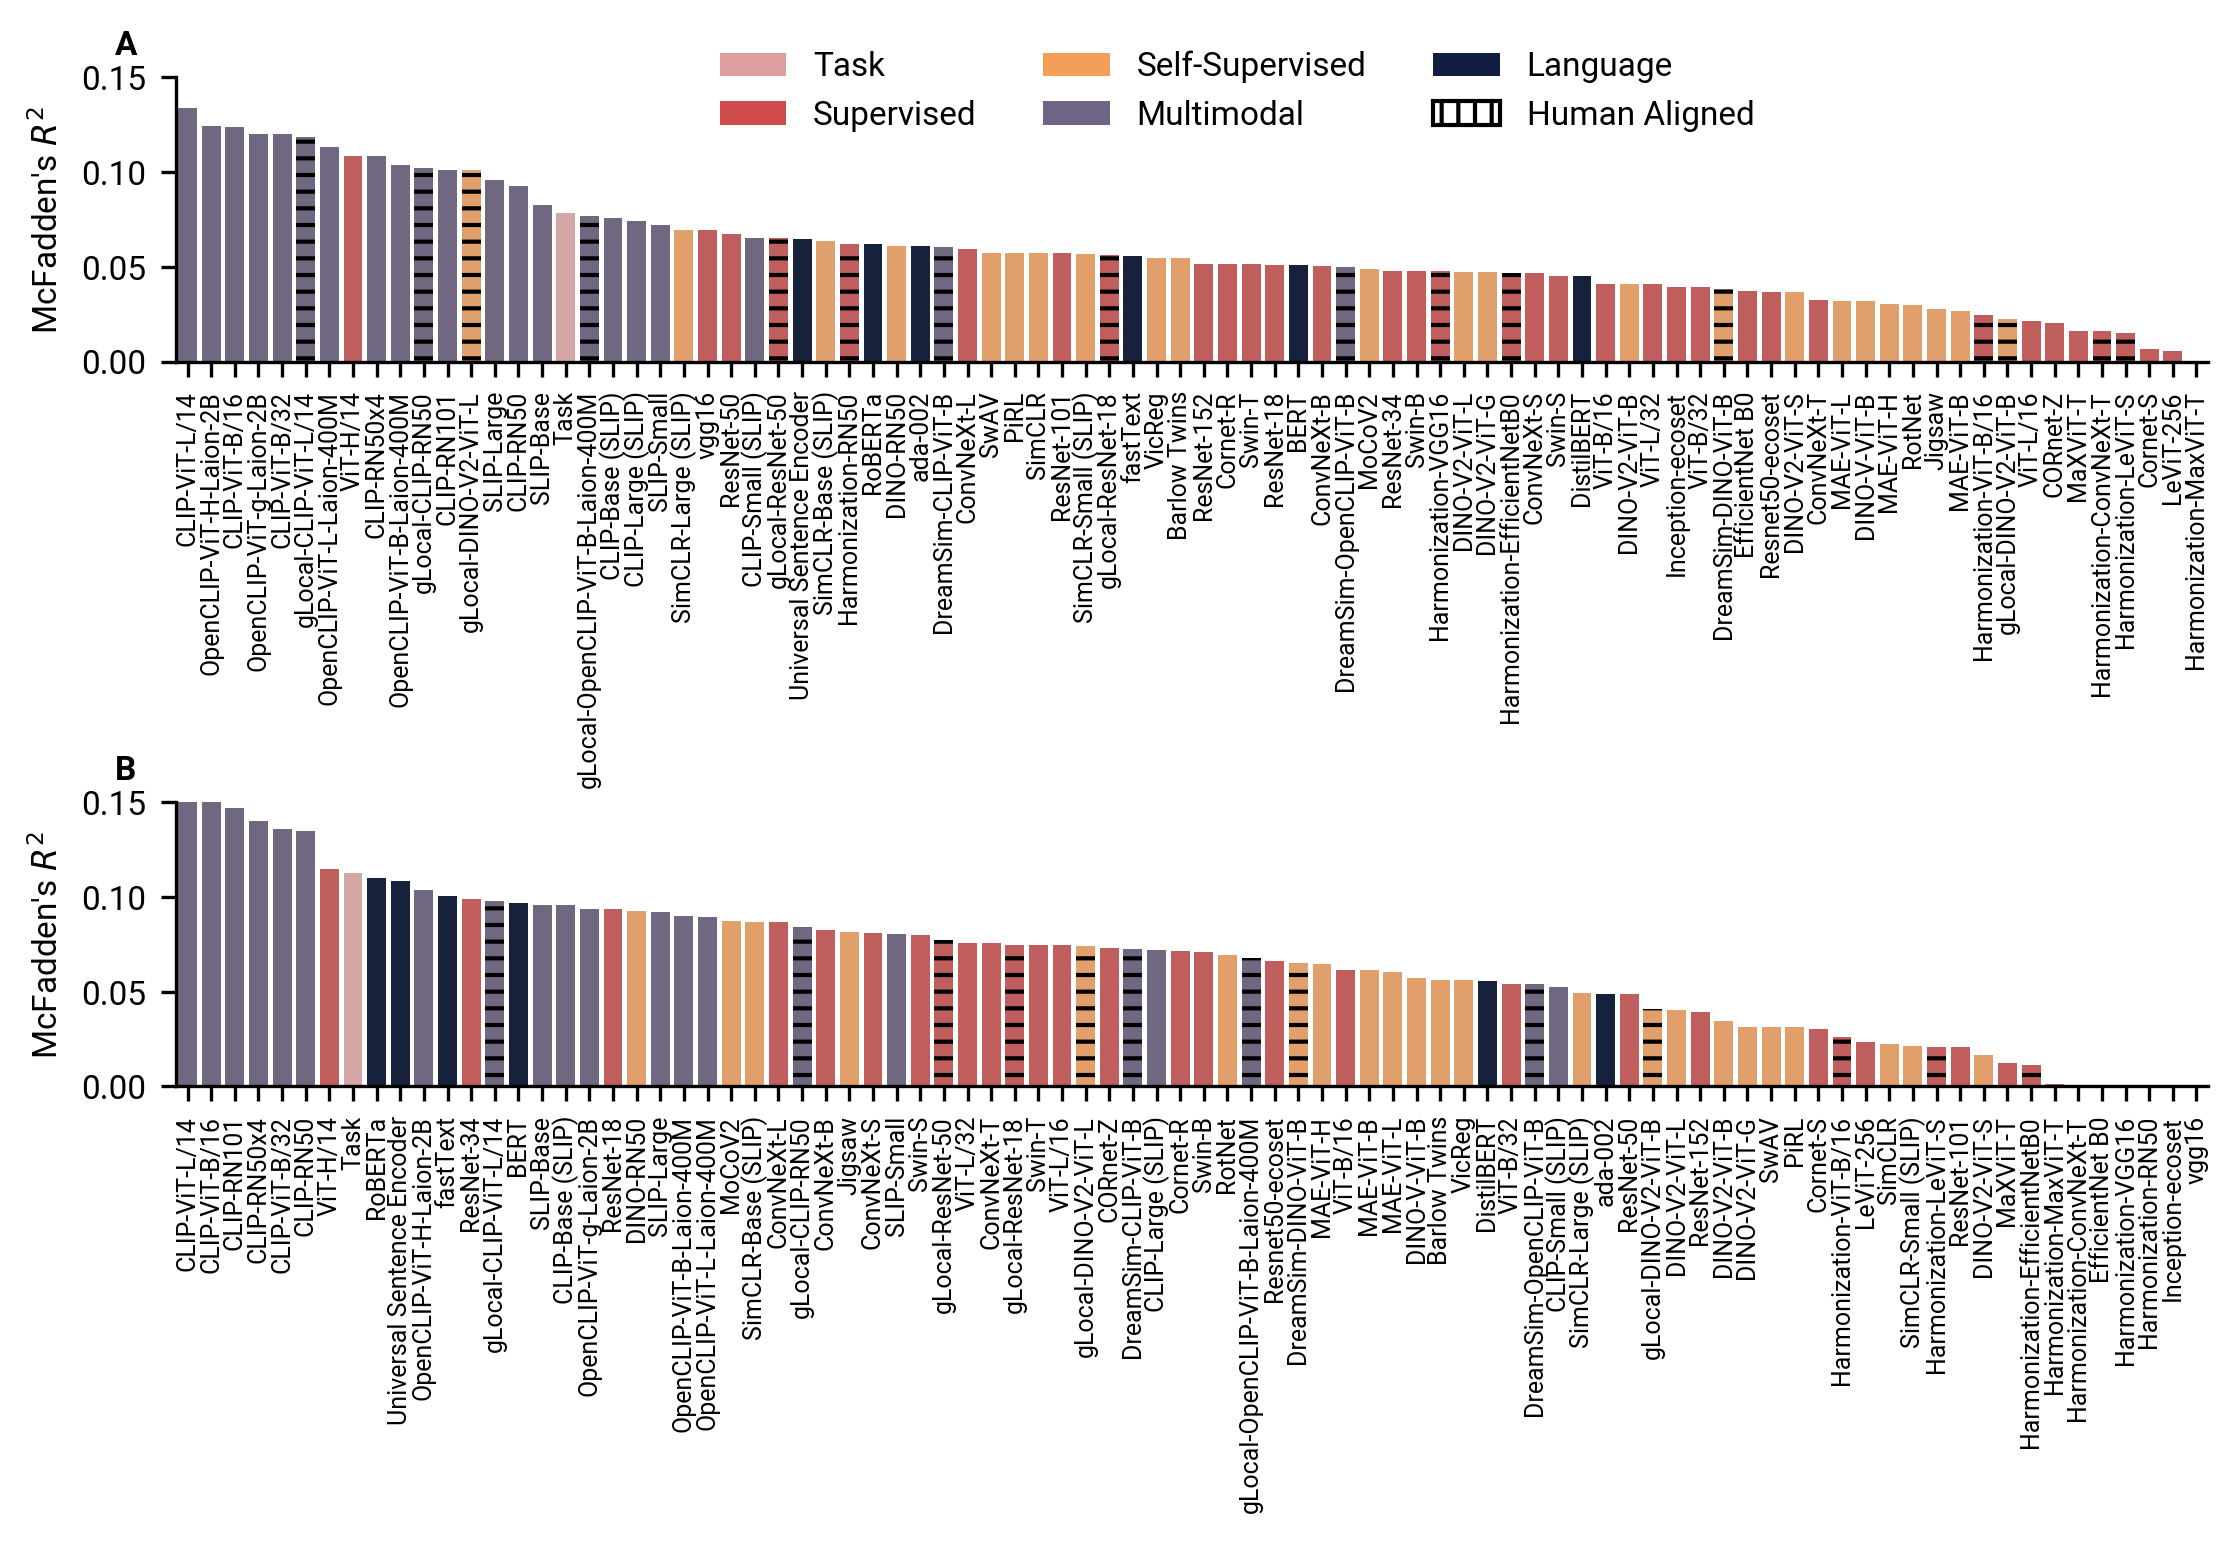

In [2]:
fig,axs = plt.subplots(2,1,figsize=(FIGWIDTH, FIGWIDTH/1.5),sharey=False)
plt.rcParams.update({'hatch.color': "k"})

dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "category_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob),np.log(1 - model_df.prob)
)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["return"] = np.where(np.round(model_df.prob) == model_df.true_category_binary, 1, 0)
chance_level = -model_df.participant.nunique() * CATEGORYTRIALS * np.log(0.5)
model_df = model_df.groupby("features").agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["feature_key"] = model_df["features"]
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
model_df.loc[model_df.nll==1]["nll"] = 0
category_model_df = model_df
num_hue_levels = model_df['color'].nunique()

# Repeat the hatches list for each hue level
sns.barplot(
    data=model_df,
    x="features",
    y="nll",
    hue="color",
    dodge=False,
    ax=axs[0],
    hue_order=[
        "task",
        "supervised",
        "self-supervised",
        "multimodal",
        "text",
    ],
)
hatches = ["---" if x=="True" else "" for x in model_df.alignment.values] * num_hue_levels
bar_patches = [patch for patch in axs[0].patches 
               if isinstance(patch, plt.Rectangle) and patch.get_height() > 0]

# Sort the patches by their x-coordinate to ensure left-to-right order
bar_patches_sorted = sorted(bar_patches, key=lambda patch: patch.get_x())
for hatch, patch in zip(hatches, bar_patches_sorted):
    patch.set_hatch(hatch)
axs[0].legend_.remove()
axs[0].tick_params(axis="x", which="major", labelsize=SMALLER_SIZE)
axs[0].xaxis.set_tick_params(rotation=90)
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("")
axs[0].text(-0.03, 1.08, string.ascii_uppercase[0], transform=axs[0].transAxes, weight="bold")


custom_legend_lines = [
    mpatches.Patch(
        facecolor=x,
        edgecolor=None,
        lw=2,
    )
    for x in CMAP[:5]
]


human_aligned_bar = mpatches.Patch(facecolor='none', edgecolor="k", hatch='|||', label='Human Aligned')



dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "reward_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["prob"] = np.where(model_df.prob == 1, 0.99999, model_df.prob)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob), np.log(1 - model_df.prob)
)
chance_level = -model_df.participant.nunique() * REWARDTRIALS * np.log(0.5)
model_df["model_choice"] = np.where(model_df.right_value > model_df.left_value, 1,0)
model_df["best_side"] = np.where(model_df.right_reward > model_df.left_reward, 1, 0)
model_df["return"] = np.where(model_df.model_choice == model_df.best_side,1,0)
model_df = model_df.groupby("features").agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["feature_key"] = model_df["features"]
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
reward_model_df = model_df

num_hue_levels = model_df['color'].nunique()

# Repeat the hatches list for each hue level

sns.barplot(
    data=model_df,
    x="features",
    y="nll",
    hue="color",
    dodge=False,
    ax=axs[1],
    hue_order=[
        "task",
        "supervised",
        "self-supervised",
        "multimodal",
        "text",
    ],
)
hatches = ["---" if x=="True" else "" for x in model_df.alignment.values] * num_hue_levels
bar_patches = [patch for patch in axs[1].patches 
               if isinstance(patch, plt.Rectangle) and patch.get_height() > 0]

# Sort the patches by their x-coordinate to ensure left-to-right order
bar_patches_sorted = sorted(bar_patches, key=lambda patch: patch.get_x())
for hatch, patch in zip(hatches, bar_patches_sorted):
    patch.set_hatch(hatch)
axs[1].legend_.remove()

axs[1].xaxis.set_tick_params(rotation=90)
axs[0].set_ylabel(r"McFadden's $R^2$")
axs[1].set_ylabel(r"McFadden's $R^2$")
axs[1].set_xlabel("")

axs[1].tick_params(axis="x", which="major", labelsize=SMALLER_SIZE)
axs[1].tick_params(axis="x", which="major", labelsize=SMALLER_SIZE)


axs[1].text(-0.03, 1.08, string.ascii_uppercase[1], transform=axs[1].transAxes, weight="bold")
def two_decimals(x, pos):
    return f'{x:.2f}'

axs[1].yaxis.set_major_formatter(FuncFormatter(two_decimals))


custom_legend_lines.append(human_aligned_bar)
hue_order = [
    "Task",
    "Supervised",
    "Self-Supervised",
    "Multimodal",
    "Language",
]
hue_order.append("Human Aligned")
fig.legend(
    custom_legend_lines,
    hue_order,
    loc="center",
    bbox_to_anchor=(0.56, .98),
    ncol=3,
    frameon=False,
)
plt.tight_layout(pad=-1.5)

axs[0].set_ylim(0.,.15)
axs[1].set_ylim(0.,.15)
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


plt.show()


fig.savefig(join(PROJECT_ROOT, "figures","neurips_nll.pdf"), bbox_inches='tight')